<a href="https://colab.research.google.com/github/archanaanbalagan11/Fraud-Detection/blob/main/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

df = pd.read_csv("Fraud.csv")
print(df.head())


Saving Fraud.csv to Fraud.csv
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [ ]:
df.to_parquet("Fraud.parquet")
df=pd.read_parquet("Fraud.parquet")
print(df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [ ]:
import os
print(os.path.exists(r"C:\Users\Dell\Downloads\Fraud.csv"))


False


Initial shape: (1048575, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'n

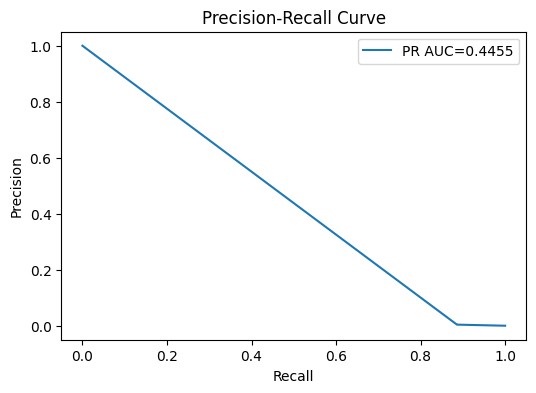

           feature    importance
4    oldbalanceOrg  9.362468e+13
8   newbalanceDest  6.824636e+13
7   oldbalanceDest  2.303895e+13
5   newbalanceOrig  9.839854e+12
3         nameOrig  6.094822e+12
6         nameDest  4.555485e+12
1             type  3.902772e+12
2           amount  1.788530e+12
10      amount_log  9.369559e+11
0             step  8.070459e+11
11         amt_bin  6.755741e+10
9   isFlaggedFraud  0.000000e+00


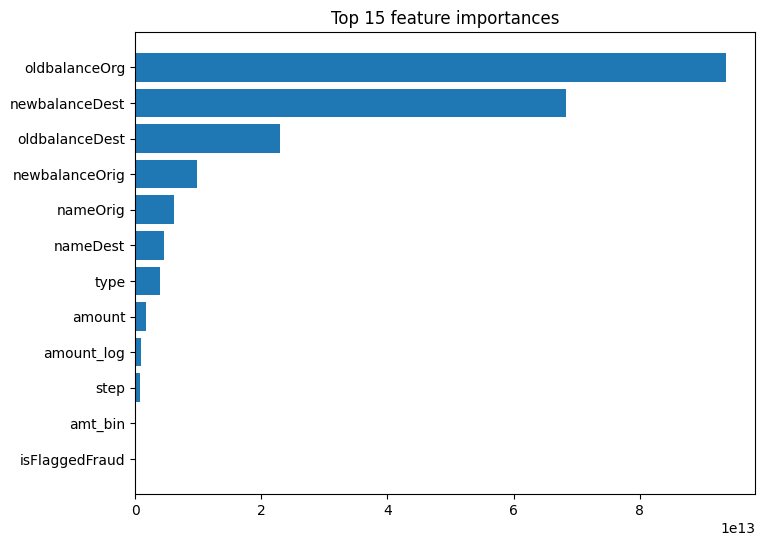

In [ ]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("Install imbalanced-learn if needed: pip install imblearn")
    SMOTE = None
try:
    import lightgbm as lgb
except ImportError:
    print("Install lightgbm if needed: pip install lightgbm")
    lgb = None
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:3] != 'dat':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Mem usage: {start_mem:.2f} MB → {end_mem:.2f} MB "
              f"({100*(start_mem-end_mem)/start_mem:.1f}% reduction)")
    return df
file_path = "Fraud.csv"
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("Initial shape:", df.shape)
    print(df.head())
else:
    print(f"Error: File not found at {file_path}. Please ensure the file is uploaded and accessible.")
    # Optionally exit or handle the missing file case
    # exit()

if 'df' in locals(): # Check if df was loaded successfully
    print(df.columns.tolist())
    df.info()

    # Detect target column (assuming 'is_fraud' or similar)
    target_col = None
    for c in df.columns:
        if c.lower() in ['is_fraud', 'fraud', 'label', 'isfraud', 'fraud_flag']:
            target_col = c
            break
    if target_col is None:
        raise ValueError("Target column not found — set target_col manually.")

    print("Target column:", target_col)
    print(df[target_col].value_counts(normalize=True))

    # Drop duplicates
    if df.duplicated().sum() > 0:
        df = df.drop_duplicates().reset_index(drop=True)

    # Reduce memory
    df = reduce_mem_usage(df)

    date_col = None
    for c in df.columns:
        if 'date' in c.lower() or 'time' in c.lower():
            date_col = c
            break
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df['tx_hour'] = df[date_col].dt.hour.astype('Int16')
        df['tx_dayofweek'] = df[date_col].dt.dayofweek.astype('Int8')
        df['tx_day'] = df[date_col].dt.day.astype('Int8')

    # Amount features
    amt_col = None
    for c in df.columns:
        if 'amount' in c.lower() or 'amt' in c.lower():
            amt_col = c
            break
    if amt_col:
        df['amount_log'] = np.log1p(df[amt_col].astype(float))
        df['amt_bin'] = pd.qcut(df[amt_col].astype(float).fillna(0), q=10, duplicates='drop').astype('category')

    # Customer transaction count
    cust_col = None
    for c in df.columns:
        if 'cust' in c.lower() or 'customer' in c.lower():
            cust_col = c
            break
    if cust_col:
        tx_count = df.groupby(cust_col).size().rename('cust_tx_count')
        df = df.merge(tx_count, left_on=cust_col, right_index=True, how='left')
        df['cust_tx_count'] = df['cust_tx_count'].astype('int32')

    # Drop columns that are not useful for modeling
    drop_cols = []
    for c in df.columns:
        if 'id' in c.lower() and c != cust_col:
            drop_cols.append(c)
    if date_col:
        drop_cols.append(date_col)

    X = df.drop(columns=drop_cols + [target_col], errors='ignore')
    y = df[target_col].astype(int)


    label_encoders = {}
    for c in X.select_dtypes(include=['category', 'object']).columns:
        le = LabelEncoder()
        X[c] = X[c].astype(str).fillna('NA')
        X[c] = le.fit_transform(X[c])
        label_encoders[c] = le


    X = X.fillna(-999)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    if lgb: # Check if lightgbm was imported successfully
        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'metric': 'auc',
            'learning_rate': 0.05,
            'num_leaves': 64,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'seed': 42,
            'verbosity': -1,
            'is_unbalance': True
        }

        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_eval],
            num_boost_round=2000
        )

        y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred = (y_pred_proba >= 0.5).astype(int)

        print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
        print(classification_report(y_test, y_pred))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        print("PR AUC:", pr_auc)

        plt.figure(figsize=(6,4))
        plt.plot(recall, precision, label=f'PR AUC={pr_auc:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

        fi = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importance(importance_type='gain')
        }).sort_values('importance', ascending=False)

        print(fi.head(20))
        plt.figure(figsize=(8,6))
        plt.barh(fi['feature'].head(15)[::-1], fi['importance'].head(15)[::-1])
        plt.title("Top 15 feature importances")
        plt.show()
    else:
        print("LightGBM not imported. Skipping model training and evaluation.")
else:
    print("DataFrame 'df' not created due to file loading error. Skipping subsequent steps.")